## Import libraries

In [1]:
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

from Sensitivity_SRC_SRRC import sensitivity_analysis

## User Input

In [8]:
# choosing the supply temperature to analyse the data for
suplyT = input("Analyse for (MT/LT): ")

# Specify the global sensitivity analysis method
# if R2 is lower than 0.75 choose SRRC other SRC
sens_type = input("Choose Analysis method (SRRC/SRC): ")

Analyse for (MT/LT):  LT
Choose Analysis method (SRRC/SRC):  SRRC


## File handeling

In [9]:
# Directory where all the Excel files are stored
current_dir = Path().resolve()
MT_data_dir = current_dir/'Data_Med_Temp'
LT_data_dir = current_dir/'Data_Low_Temp'

# Define your input columns and output columns for heating demand and cold hours
input_col = ['orientation', 'compactness_ratio','WWR', 'Rc_Gr', 'Rc_Wl', 'Rc_Rf', 'U_Gz', 'U_Dr', 'Inf', 'Vent_sys', 'Temp_set']
output_cols = ['Heating_demand', 'Underheated_hours']

if suplyT == "MT":
    directory = MT_data_dir
else:
    directory = LT_data_dir

### Reading and processing data from output excels

In [10]:
# Initialize a DataFrame to store the sensitivity values for each parameter, sample size, and output
srrc_dfs = {col: pd.DataFrame(index=input_col) for col in output_cols}

# Initialize a DataFrame to store the rankings for each parameter and sample size
ranking_dfs = {col: pd.DataFrame(index=input_col) for col in output_cols}

# Initialize a DataFrame to store the R2 values for each parameter and sample size
r2_dfs = {col: pd.Series(dtype=float) for col in output_cols}

for filename in os.listdir(directory):
    if filename.endswith(".xlsx"):
        # Full file path
        file_path = os.path.join(directory, filename)
        
        # Load data to calculate number of samples
        df = pd.read_excel(file_path)
        
        # Check if the DataFrame contains any NaN values
        if df.isnull().values.any():
            print(f"The file {file_path} contains NaN values.")
            # Skip this file and move on to the next one
            continue
            
    num_samples = len(df)
     
    for output_col in output_cols:
        # Perform sensitivity analysis and get R-squared value
        srf_df , input_sample, input_col, output_sample, R2 = sensitivity_analysis(file_path, input_col, output_col, sens_type)
        
        # Process SRRC values and rankings
        srf_df[sens_type] = srf_df[sens_type].abs()
        srf_df_sorted = srf_df.sort_values(by=sens_type, ascending=False)
       
        # Update SRRC DataFrame
        srrc_dfs[output_col][f'Sample Size {num_samples}'] = srf_df.set_index('Variable')['SRRC']
       
        # Update Rankings DataFrame
        ranking_dfs[output_col][f'Sample Size {num_samples}'] = pd.Series(data=range(1, len(srf_df_sorted)+1), index=srf_df_sorted['Variable'])
        
        # Update R2 DataFrame
        r2_dfs[output_col][f'Sample Size {num_samples}'] = R2

# Transpose the DataFrame
# Sort the columns by sample size
for output_col in output_cols:
    srrc_dfs[output_col] = srrc_dfs[output_col].sort_index(axis=1, key=lambda x: x.str.extract('(\d+)', expand=False).astype(int))
    ranking_dfs[output_col] = ranking_dfs[output_col].sort_index(axis=1, key=lambda x: x.str.extract('(\d+)', expand=False).astype(int))
    r2_dfs[output_col] = r2_dfs[output_col].sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(int))

### Plotting Results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\prateekwahi\AppData\Local\Temp\ipykernel_11088\2292296943.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


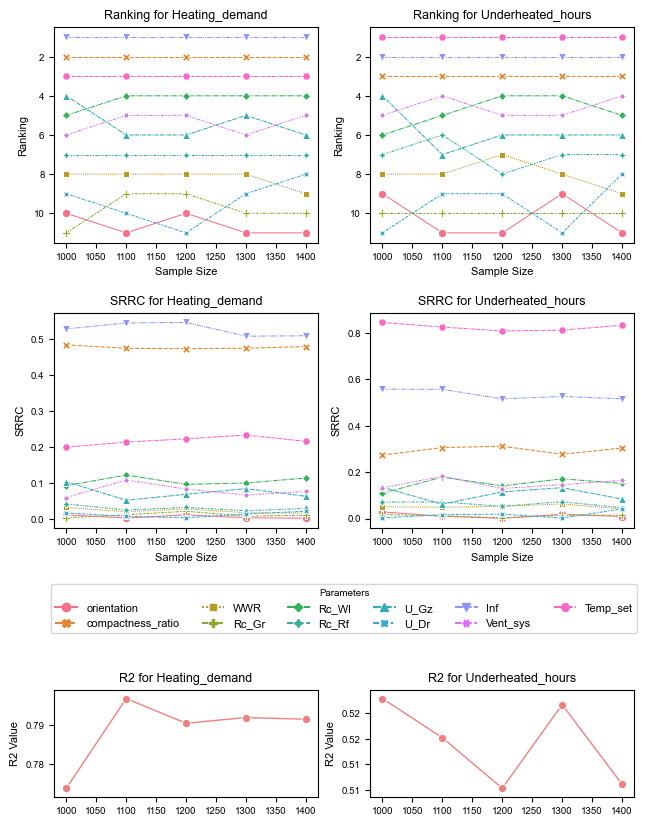

In [11]:
# Update matplotlib's rcParams to set Arial as the default font for all text elements
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7  # Default font size for all text

def extract_sample_size(x):
    return int(x.split()[2])

def plot_with_seaborn(output_cols, ranking_dfs, srrc_dfs, r2_dfs):
    num_outputs = len(output_cols)
    
    # Assuming a desired figure width of 7.48 inches for 19 cm, and adjusting height for clarity
    fig_width = 7.48
    fig_height = 10
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create a GridSpec with 4 rows and num_outputs columns,
    # with heights for the rows specifically set for the graphs and the legend.
    gs = gridspec.GridSpec(4, num_outputs, height_ratios=[3, 3, 0.3, 1.5], hspace=0.5)

    # Variables to hold the legend handles and labels
    legend_handles = None
    legend_labels = None

    for col_index, output_col in enumerate(output_cols):
        ranking_df_long = ranking_dfs[output_col].reset_index().melt(id_vars='index', var_name='Sample Size', value_name='Ranking')
        srrc_df_long = srrc_dfs[output_col].reset_index().melt(id_vars='index', var_name='Sample Size', value_name='SRRC')
        
        ranking_df_long['Sample Size Num'] = ranking_df_long['Sample Size'].apply(extract_sample_size)
        srrc_df_long['Sample Size Num'] = srrc_df_long['Sample Size'].apply(extract_sample_size)
        
        # Use GridSpec for subplot locations
        ax0 = fig.add_subplot(gs[0, col_index])
        ax1 = fig.add_subplot(gs[1, col_index])
        ax2 = fig.add_subplot(gs[3, col_index])
        
        # Plotting the ranking
        palette = sns.color_palette("husl", n_colors=len(ranking_df_long['index'].unique()))
        ranking_plot = sns.lineplot(data=ranking_df_long, x='Sample Size Num', y='Ranking', hue='index', style='index', markers=True, linewidth=0.75, markersize=6, ax=ax0, palette=palette)
        ax0.set_title(f'Ranking for {output_col}', fontsize=9)
        ax0.invert_yaxis()
        ax0.set_ylabel('Ranking', fontsize=8)
        ax0.set_xlabel('Sample Size', fontsize=8)
        
        # Plotting the SRRC
        srrc_plot = sns.lineplot(data=srrc_df_long, x='Sample Size Num', y='SRRC', hue='index', style='index', markers=True, linewidth=0.75, markersize=6, ax=ax1, palette = palette)
        ax1.set_title(f'SRRC for {output_col}', fontsize=9)
        ax1.set_ylabel('SRRC', fontsize=8)
        ax1.set_xlabel('Sample Size', fontsize=8)
        
        # Plotting the R2
        r2_series = r2_dfs[output_col].dropna()
        r2_sample_sizes = r2_series.index.map(extract_sample_size)
        sns.lineplot(x=r2_sample_sizes, y=r2_series.values, marker='o', linewidth=1, markersize=6, color='lightcoral', ax=ax2)
        ax2.set_title(f'R2 for {output_col}', fontsize=9)
        ax2.set_ylabel('R2 Value', fontsize=8)
        
        # Calculate buffer based on the range of the data
        r2_min, r2_max = r2_series.min(), r2_series.max()
        buffer = (r2_max - r2_min) * 0.1  # 10% buffer above and below
        ax2.set_ylim(r2_min - buffer, r2_max + buffer)
        
        # Set Y-axis to display numbers with two decimal places
        ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        
        # Adjusting the tick label size
        ax0.tick_params(labelsize=7)
        ax1.tick_params(labelsize=7)
        ax2.tick_params(labelsize=7)
        
        # Remove legends from individual plots
        ax0.get_legend().remove()
        ax1.get_legend().remove()
        ax2.legend().set_visible(False)
        
        # Set legend handles and labels from the first subplot
        if col_index == 0:
            legend_handles, legend_labels = ax0.get_legend_handles_labels()
    
    # Place the legend in the empty row created for it
    ax_legend = fig.add_subplot(gs[2, :])  # Span the legend across all columns
    ax_legend.legend(legend_handles, legend_labels, loc='center', ncol=6, fontsize='8', title = "Parameters")
    ax_legend.axis('off')  # Turn off the axis
    
    plt.tight_layout()
    
    # Save the figure
    image_name = f"appro_size_apt_{suplyT}.png"
    image_save_dir = os.path.join(current_dir/'Assets', image_name)
    plt.savefig(image_save_dir, dpi=300, bbox_inches='tight', pad_inches=0.1)  # png format
    
    plt.show()

# Example call to the function
plot_with_seaborn(output_cols, ranking_dfs, srrc_dfs, r2_dfs)
